##### Training

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [25]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, ), std=(0.5, ))
    ]
)

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

traning_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


T-shirt/top  Sneaker  Trouser  Bag


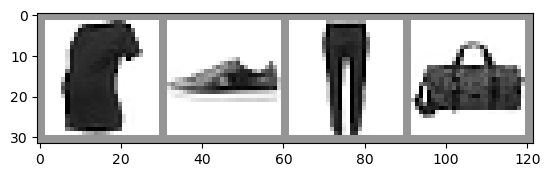

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def matplotlib_imshow(img, one_channel = False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(traning_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = GarmentClassifier()

In [28]:
loss_fn = torch.nn.CrossEntropyLoss()

dummy_outputs = torch.rand(4, 10)
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.6918, 0.2298, 0.7432, 0.1030, 0.6676, 0.6574, 0.0271, 0.4314, 0.3971,
         0.4455],
        [0.3088, 0.0681, 0.2573, 0.3310, 0.4195, 0.1442, 0.2493, 0.9157, 0.3550,
         0.9069],
        [0.6887, 0.4611, 0.9999, 0.9255, 0.8689, 0.1257, 0.7117, 0.1492, 0.9057,
         0.6840],
        [0.5065, 0.1807, 0.4169, 0.9176, 0.7438, 0.7595, 0.2737, 0.7223, 0.2248,
         0.2563]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.3296384811401367


In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [30]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(traning_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print('   batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(traning_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            
    return last_loss

In [31]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

In [34]:
EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    writer.add_scalars('Training vs. Validation Loss',
                       {'Traning' : avg_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = './data/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1
    

EPOCH 6:
   batch 1000 loss: 0.2754822583779114
   batch 2000 loss: 0.26348238086472703
   batch 3000 loss: 0.27280601649183517
   batch 4000 loss: 0.2690154216703231
   batch 5000 loss: 0.2707005743347449
   batch 6000 loss: 0.2720331478058506
   batch 7000 loss: 0.2742315559081799
   batch 8000 loss: 0.26641434028969707
   batch 9000 loss: 0.28874686932983606
   batch 10000 loss: 0.2708307335197676
   batch 11000 loss: 0.2581585292113741
   batch 12000 loss: 0.27086213325680136
   batch 13000 loss: 0.2858723176418325
   batch 14000 loss: 0.2876848262638341
   batch 15000 loss: 0.2656811610095419
LOSS train 0.2656811610095419 valid 0.2970227003097534
EPOCH 7:
   batch 1000 loss: 0.23495637004556238
   batch 2000 loss: 0.24901419111285258
   batch 3000 loss: 0.2489811041764101
   batch 4000 loss: 0.2507939982153239
   batch 5000 loss: 0.24706700242277657
   batch 6000 loss: 0.26835173479780494
   batch 7000 loss: 0.26932692031400074
   batch 8000 loss: 0.26097353185187605
   batch 9000

In [35]:
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>